# Install Some Improtant Dependencies

In [ ]:
! pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q
!pip install accelerate -U

  Using cached accelerate-0.28.0-py3-none-any.whl (290 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 k

# Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Dataset

In [ ]:
from datasets import load_dataset
ds = load_dataset("arattinger/noto-emoji-captions")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3468 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 3468
    })
})

In [ ]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 3121
})

In [ ]:
test_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 347
})

Let's visualize a couple of samples from the training set.

In [ ]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [ ]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

With the dataset ready, we can now set up the model for fine-tuning

In [ ]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

# Load a base model

Load the ["microsoft/git-base"](https://huggingface.co/microsoft/git-base) into a [`AutoModelForCausalLM`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM) object.

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

# Evaluate

In [ ]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

# Train

Now, we are ready to start fine-tuning the model. We will use the 🤗 [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) for this.

First, define the training arguments using [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=2,
    fp16=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    # push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
    # eval_accumulation_steps=1
)

Then pass them along with the datasets and the model to 🤗 Trainer.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=None,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


To start training, simply call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) on the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
50,7.484600,4.555060
100,2.325100,0.401424
150,0.131500,0.040420
200,0.037800,0.030851
250,0.030200,0.027427
300,0.026500,0.024598
350,0.025300,0.024375
400,0.022700,0.021994
450,0.017100,0.020497
500,0.017100,0.019161


TrainOutput(global_step=780, training_loss=0.6533403360690826, metrics={'train_runtime': 867.4741, 'train_samples_per_second': 7.196, 'train_steps_per_second': 0.899, 'total_flos': 2916936612108288.0, 'train_loss': 0.6533403360690826, 'epoch': 2.0})

# Sav the model in drive

In [ ]:
model_save_path = "/content/drive/MyDrive/Image_Captioning/Model_weights"
trainer.save_model(model_save_path)

# Inference

Take a sample image from `test_ds` to test the model.

In [ ]:
from PIL import Image
import requests

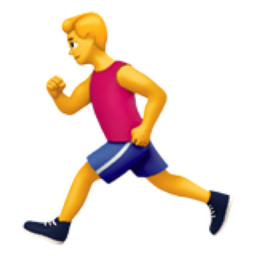

In [ ]:
from PIL import Image
import requests
url = "https://clipground.com/images/walking-emoji-png-15.png"
image = Image.open(requests.get(url, stream=True).raw)
image

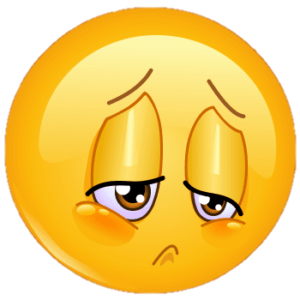

In [ ]:
url = "https://pngfre.com/wp-content/uploads/sad-emoji-png-image-from-pngfre-12-300x300.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

Call `generate` and decode the predictions.

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a yellow emoticion with a sad face


# Sentiment Analysis

Giving a sample data for sentiment analysis

In [ ]:
train_data = ["a happy face", "a sad face", "a neutral face", "an angry face"]
test_data = ["a positive face", "a negative face", "a neutral face", "an angry face"]
train_labels = ["positive", "negative", "neutral", "angry"]
test_labels = ["positive", "negative", "neutral", "angry"]

Mapping the labels back to sentimnt analysis

In [ ]:
label_map = {0: "positive", 1: "negative", 2: "neutral", 3: "angry"}

Using [google-bert/bert-base-uncased](https://) for sentiment analysis

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Inference

In [ ]:
# Prompt for user input
caption = input("Enter the caption: ")
# Tokenize the caption
encoding = tokenizer(caption, truncation=True, padding=True, return_tensors='pt')
with torch.no_grad():
    outputs = model(**encoding)

# Getting the predicted label
predicted_label = torch.argmax(outputs.logits).item()
predicted_sentiment = label_map[predicted_label]

# Print predicted sentiment
print("Predicted Sentiment:", predicted_sentiment)

Enter the caption: a man running in a purple shirt
Predicted Sentiment: negative


# Save the model to drive

In [ ]:
output_dir = "/content/drive/MyDrive/Image_Captioning/Model_weights"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/Image_Captioning/Model_weights/tokenizer_config.json',
 '/content/drive/MyDrive/Image_Captioning/Model_weights/special_tokens_map.json',
 '/content/drive/MyDrive/Image_Captioning/Model_weights/vocab.txt',
 '/content/drive/MyDrive/Image_Captioning/Model_weights/added_tokens.json')

# Sentiment with GPT MODEL

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
model = AutoModelForSequenceClassification.from_pretrained("EleutherAI/gpt-neo-125M")
caption = input("Enter the caption: ")

inputs = tokenizer(caption, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

predicted_label = torch.argmax(outputs.logits).item()

sentiment_labels = {0: "Positive", 1: "Negative", 2: "Neutral"}

predicted_sentiment = sentiment_labels[predicted_label]
print("Predicted Sentiment:", predicted_sentiment)

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter the caption: a yellow emoticion with a sad face
Predicted Sentiment: Negative
